In [1]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('../../..')
sys.path.append('../../../lib/src/')
sys.path.append('../../../TopographicVAE-master')
import torch
from torch import nn
import torch.nn.functional as F
import os
from itertools import islice
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config, LVAE_IAF
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, Encoder_ColorMNIST,Decoder_ColorMNIST
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling

from tvae.data.mnist import DualTransformPreprocessor, PersepctivePreprocessor, Preprocessor
from tvae.utils.logging import get_dirs


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(grid, color=True):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()

def extract_dataset(loader):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset

%reload_ext autoreload
%autoreload 2

!nvidia-smi

Wed Jul 31 15:25:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   37C    P8             10W /   70W |     923MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([8000, 8, 1, 28, 28])
torch.Size([4000, 8, 1, 28, 28])
torch.Size([10, 8, 1, 28, 28])


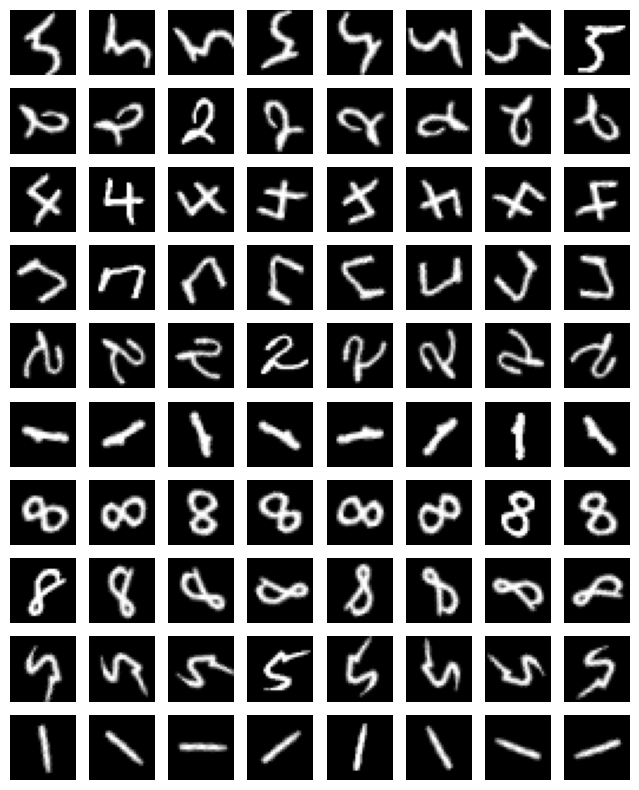

In [3]:
#ROTCOLOR MNIST
# config = {
#     'wandb_on': False,
#     'lr': 1e-4,
#     'momentum': 0.9,
#     ########################
#     'batch_size': 32,
#     ########################
#     'max_epochs': 100,
#     'eval_epochs': 5,
#     'dataset': 'MNIST',
#     'train_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'test_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340', 
#     'train_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'test_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'train_scale_set': '1.0',
#     'test_scale_set': '1.0',
#     'pct_val': 0.2,
#     'random_crop': 28,
#     'seed': 1,
#     'n_caps': 18,
#     'cap_dim': 18,
#     'n_transforms': 18,
#     'mu_init': 30.0,
#     'n_off_diag': 1,
#     'group_kernel': (13, 13, 1),
#     'train_eq_loss': False,
#     'n_is_samples': 10
#     }

config = {
    'wandb_on': False,
    'lr': 1e-4,
    'momentum': 0.9,
    ########################
    'batch_size': 32,
    ########################
    'max_epochs': 100,
    'eval_epochs': 5,
    'dataset': 'MNIST',
    'train_angle_set': '0 40 80 120 200 240 280 320',
    'test_angle_set': '0 40 80 120 200 240 280 320', 
    'train_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
    'test_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
    'train_scale_set': '1.0',
    'test_scale_set': '1.0',
    'pct_val': 0.2,
    'random_crop': 28,
    'seed': 1,
    'n_caps': 18,
    'cap_dim': 18,
    'n_transforms': 12,
    'mu_init': 30.0,
    'n_off_diag': 1,
    'group_kernel': (13, 13, 1),
    'train_eq_loss': False,
    'n_is_samples': 10
    }

name = 'TVAE_Rotation&Color-MNIST_L=13/36_K=3'

config['savedir'], config['data_dir'], config['wandb_dir'] = get_dirs()

savepath = os.path.join(config['savedir'], name)
preprocessor = Preprocessor(config, transform = 'rotation', coloring = False)
train_loader, val_loader, test_loader = preprocessor.get_dataloaders(batch_size=config['batch_size'])

train_loader = list(islice(train_loader, 250))
val_loader = list(islice(val_loader, 125))

train_data = extract_dataset(train_loader)
eval_data = extract_dataset(val_loader)
print(train_data.shape)
print(eval_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)


x = next(iter(train_loader))
imgs = x[0].squeeze(2, 3)[:10]
print(imgs.shape)
plot_sequence(imgs, color=False)

In [6]:
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-07-30_15-31-52-rotmnist/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_4_rot/checkpoints/epoch=49-step=1600.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data.reshape(-1,1,28,28)[torch.randint(low = 0, high = train_data.shape[0], size = (30000,))], verbose = True, T_multiplier=1, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

h,w = 28, 28
input_dim = (3, h, w)
f = 7 #subsampling factor
latent_dim = 1* (h // f) * (w // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with 

Finding temperature
Best temperature found:  1.9319548606872559
Building metric
Increasing T by  1
Adding std normal to centroids and var
Latent dim: 16
Number of parameters in the diffusion model:  2223043


In [7]:
model_config = LVAE_IAF_Config(
    input_dim=(1, 28, 28),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=10,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=5*1e-4,
        batch_size=128,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_ColorMNIST(model_config).to(device)
decoder = Decoder_ColorMNIST(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)

# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                  pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                  precomputed_zT_samples=None, verbose = True, temp = temperature)

model = LVAE_IAF(model_config, encoder, decoder).cuda()

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


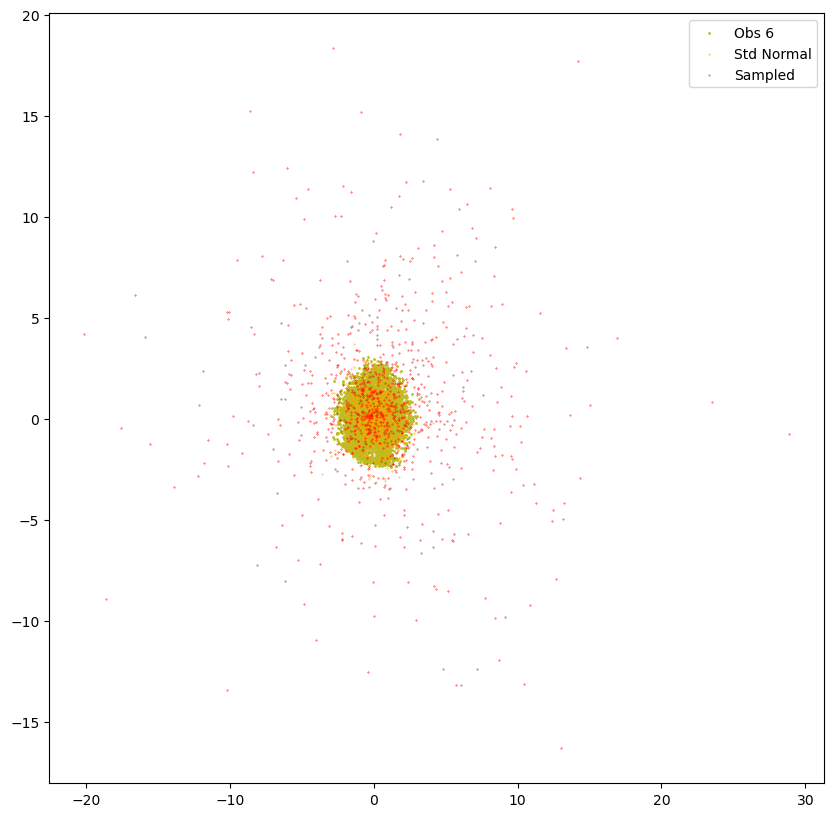

In [9]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 8
DISPLAYED_OBS =  [6]
PROJECTING_OBS = [6]
NUM_POINTS = 1000
#########

train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0]*train_dataset.data.shape[1])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

#all_z_pca = pca.transform(all_z.cpu().detach().numpy())
#p_pca  = pca.transform(p.cpu().detach().numpy())
colors = plt.get_cmap('tab10', NUM_OBS)




plt.figure(figsize=(10, 10))
for i in DISPLAYED_OBS:
    indices = [k % NUM_OBS == i for k in range(train_embeddings.shape[0])]
    plt.scatter(train_pca[indices, 0], train_pca[indices, 1], label=f'Obs {i}', s= 1, color = colors(i))


check = torch.randn(NUM_POINTS, 12)
check_pca = pca.transform(check.detach().numpy())

start = check.reshape(NUM_POINTS, model.c, model.h, model.w).cuda()
sampled, _, _ = lldm.ddim_sampler.sample(shape=(NUM_POINTS, model.c, model.h, model.w), x_last = start, cond=None, temperature= lldm.temperature)
sampled = sampled.reshape(NUM_POINTS, lldm.latent_dim)
sampled_pca = pca.transform(sampled.cpu().detach().numpy())

plt.scatter(check_pca[:, 0], check_pca[:, 1], s = 0.1, label='Std Normal', c = 'orange')
plt.scatter(sampled_pca[:, 0], sampled_pca[:, 1], s = 0.1, label='Sampled', c = 'red')


plt.legend()
plt.show()

In [10]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="rotMNIST_LLDM", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps = 1e-4)

### Scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[50, 100, 150, 200],
    gamma=10**(-1/4),
    verbose=True
)
trainer = BaseTrainer(
            model=model,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )

In [10]:
# for p in lldm.parameters():
#     p.requires_grad = True
# for p in lldm.pretrained_vae.parameters():
#     p.requires_grad = False
# for p in lldm.pretrained_ldm.parameters():
#     p.requires_grad = False
# lldm = lldm.to('cuda')
# lldm = lldm.train()
trainer.train()

Model passed sanity check !

Created lldm/LVAE_IAF_training_2024-07-31_15-32-54. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.9325
Eval loss: 24.4188
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.195
Eval loss: 24.0901
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8707
Eval loss: 23.641
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1908
Eval loss: 22.4888
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 22.1582
Eval loss: 21.7514
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5573
Eval loss: 21.2795
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2795
Eval loss: 21.1063
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.0824
Eval loss: 20.8925
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 20.9514
Eval loss: 20.7955
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0468
Eval loss: 22.1262
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.9641
Eval loss: 21.7615
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6358
Eval loss: 21.6343
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.6017
Eval loss: 21.5905
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.5101
Eval loss: 21.4991
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4615
Eval loss: 21.4502
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 16/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4584
Eval loss: 21.4471
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 17/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4339
Eval loss: 21.4626
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 18/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4451
Eval loss: 21.4704
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 19/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4404
Eval loss: 21.4238
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 20/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4318
Eval loss: 21.4189
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 21/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4397
Eval loss: 21.4312
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 22/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4502
Eval loss: 21.4012
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 23/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.4092
Eval loss: 21.4125
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 24/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3863
Eval loss: 21.3593
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 25/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3832
Eval loss: 21.404
--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 26/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3863
Eval loss: 21.3764
--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 27/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3705
Eval loss: 21.3532
--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 28/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.363
Eval loss: 21.3468
--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 29/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3691
Eval loss: 21.3625
--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 30/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3685
Eval loss: 21.366
--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 31/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3658
Eval loss: 21.3359
--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 32/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3597
Eval loss: 21.3276
--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 33/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.35
Eval loss: 21.3281
--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 34/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3158
Eval loss: 21.3117
--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 35/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3301
Eval loss: 21.3342
--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 36/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3225
Eval loss: 21.3399
--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 37/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3199
Eval loss: 21.305
--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 38/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3062
Eval loss: 21.2997
--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 39/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.316
Eval loss: 21.3252
--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 40/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.32
Eval loss: 21.2974
--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 41/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3201
Eval loss: 21.3106
--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 42/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3066
Eval loss: 21.3019
--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 43/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3133
Eval loss: 21.2845
--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 44/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2964
Eval loss: 21.2995
--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 45/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3045
Eval loss: 21.3165
--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 46/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2969
Eval loss: 21.3244
--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 47/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3059
Eval loss: 21.2713
--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 48/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3143
Eval loss: 21.2757
--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 49/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.3017
Eval loss: 21.3
--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 50/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Saved checkpoint at epoch 50

--------------------------------------------------------------------------
Train loss: 21.2911
Eval loss: 21.2856
--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 51/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2668
Eval loss: 21.2721
--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 52/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2611
Eval loss: 21.252
--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 53/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2747
Eval loss: 21.2507
--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 54/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.256
Eval loss: 21.2565
--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 55/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.261
Eval loss: 21.2638
--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 56/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2595
Eval loss: 21.2563
--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 57/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2476
Eval loss: 21.2504
--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 58/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2778
Eval loss: 21.2519
--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 59/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2606
Eval loss: 21.2548
--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 60/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2546
Eval loss: 21.2543
--------------------------------------------------------------------------


Training of epoch 61/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 61/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2639
Eval loss: 21.2546
--------------------------------------------------------------------------


Training of epoch 62/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 62/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2656
Eval loss: 21.2501
--------------------------------------------------------------------------


Training of epoch 63/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 63/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2469
Eval loss: 21.2598
--------------------------------------------------------------------------


Training of epoch 64/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 64/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2636
Eval loss: 21.2517
--------------------------------------------------------------------------


Training of epoch 65/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 65/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2548
Eval loss: 21.2497
--------------------------------------------------------------------------


Training of epoch 66/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 66/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2603
Eval loss: 21.2443
--------------------------------------------------------------------------


Training of epoch 67/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 67/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2546
Eval loss: 21.255
--------------------------------------------------------------------------


Training of epoch 68/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 68/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2517
Eval loss: 21.2483
--------------------------------------------------------------------------


Training of epoch 69/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 69/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2654
Eval loss: 21.255
--------------------------------------------------------------------------


Training of epoch 70/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 70/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2646
Eval loss: 21.2478
--------------------------------------------------------------------------


Training of epoch 71/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 71/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.256
Eval loss: 21.2571
--------------------------------------------------------------------------


Training of epoch 72/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 72/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2441
Eval loss: 21.255
--------------------------------------------------------------------------


Training of epoch 73/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 73/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2592
Eval loss: 21.2396
--------------------------------------------------------------------------


Training of epoch 74/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 74/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2364
Eval loss: 21.2392
--------------------------------------------------------------------------


Training of epoch 75/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 75/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2471
Eval loss: 21.2491
--------------------------------------------------------------------------


Training of epoch 76/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 76/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2626
Eval loss: 21.2474
--------------------------------------------------------------------------


Training of epoch 77/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 77/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2314
Eval loss: 21.2409
--------------------------------------------------------------------------


Training of epoch 78/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 78/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2527
Eval loss: 21.2413
--------------------------------------------------------------------------


Training of epoch 79/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 79/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2588
Eval loss: 21.2351
--------------------------------------------------------------------------


Training of epoch 80/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 80/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2411
Eval loss: 21.2544
--------------------------------------------------------------------------


Training of epoch 81/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 81/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2547
Eval loss: 21.2344
--------------------------------------------------------------------------


Training of epoch 82/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 82/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2531
Eval loss: 21.2641
--------------------------------------------------------------------------


Training of epoch 83/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 83/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2578
Eval loss: 21.2523
--------------------------------------------------------------------------


Training of epoch 84/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 84/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2597
Eval loss: 21.2448
--------------------------------------------------------------------------


Training of epoch 85/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 85/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2563
Eval loss: 21.2503
--------------------------------------------------------------------------


Training of epoch 86/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 86/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2526
Eval loss: 21.2356
--------------------------------------------------------------------------


Training of epoch 87/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 87/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2545
Eval loss: 21.2434
--------------------------------------------------------------------------


Training of epoch 88/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 88/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2475
Eval loss: 21.2492
--------------------------------------------------------------------------


Training of epoch 89/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 89/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2428
Eval loss: 21.2496
--------------------------------------------------------------------------


Training of epoch 90/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 90/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2432
Eval loss: 21.2407
--------------------------------------------------------------------------


Training of epoch 91/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 91/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2466
Eval loss: 21.2449
--------------------------------------------------------------------------


Training of epoch 92/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 92/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2598
Eval loss: 21.2431
--------------------------------------------------------------------------


Training of epoch 93/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 93/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2459
Eval loss: 21.2418
--------------------------------------------------------------------------


Training of epoch 94/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 94/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2404
Eval loss: 21.2355
--------------------------------------------------------------------------


Training of epoch 95/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 95/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2526
Eval loss: 21.2347
--------------------------------------------------------------------------


Training of epoch 96/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 96/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2411
Eval loss: 21.2416
--------------------------------------------------------------------------


Training of epoch 97/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 97/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2463
Eval loss: 21.2383
--------------------------------------------------------------------------


Training of epoch 98/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 98/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2538
Eval loss: 21.2387
--------------------------------------------------------------------------


Training of epoch 99/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 99/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 21.2498
Eval loss: 21.2255
--------------------------------------------------------------------------


Training of epoch 100/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 100/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Saved checkpoint at epoch 100

--------------------------------------------------------------------------
Train loss: 21.2423
Eval loss: 21.2413
--------------------------------------------------------------------------
Training ended!
Saved final model in lldm/LVAE_IAF_training_2024-07-31_15-32-54/final_model


In [29]:
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_14-46-51/final_model/model.pt')['model_state_dict'])
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-30_16-29-58/checkpoint_epoch_50/model.pt')['model_state_dict'])

<All keys matched successfully>

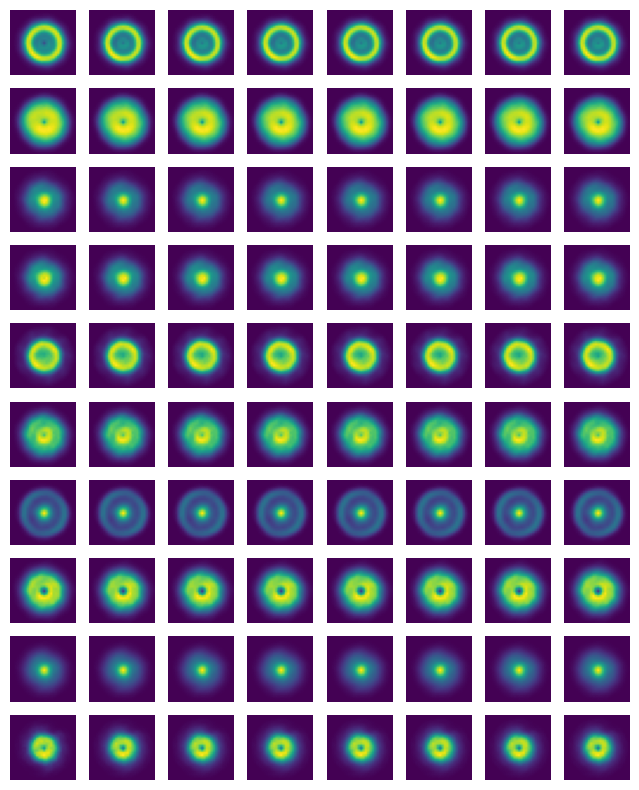

In [12]:
model = model.eval()
z = torch.randn(10, 16).cuda()
x_gen, z_seq = model.generate(z)
plot_sequence(x_gen)

In [57]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)
model = LitLDM.load_from_checkpoint('ldm_retrain/lightning_logs/version_0/checkpoints/epoch=99-step=3200.ckpt', ldm = latent_diffusion, vae = new_vae, latent_dim = latent_dim).to('cuda')
lldm.pretrained_ldm = model.ldm

for p in lldm.parameters():
    p.requires_grad = True
for p in lldm.pretrained_vae.parameters():
    p.requires_grad = False
for p in lldm.pretrained_ldm.parameters():
    p.requires_grad = False

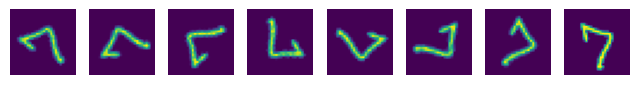

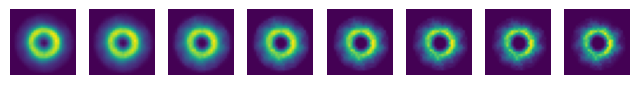

Reconstruction loss: 13.281487464904785


In [34]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm = lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 0)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [25]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = model.encoder(x)
    z = out.embedding.reshape(-1, 8, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([8000, 8, 12])


In [36]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 8, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([8000, 8, 12])


PCA on the whole dataset (64000 data points)


TypeError: BaseAE.reconstruct() got an unexpected keyword argument 'vi_index'

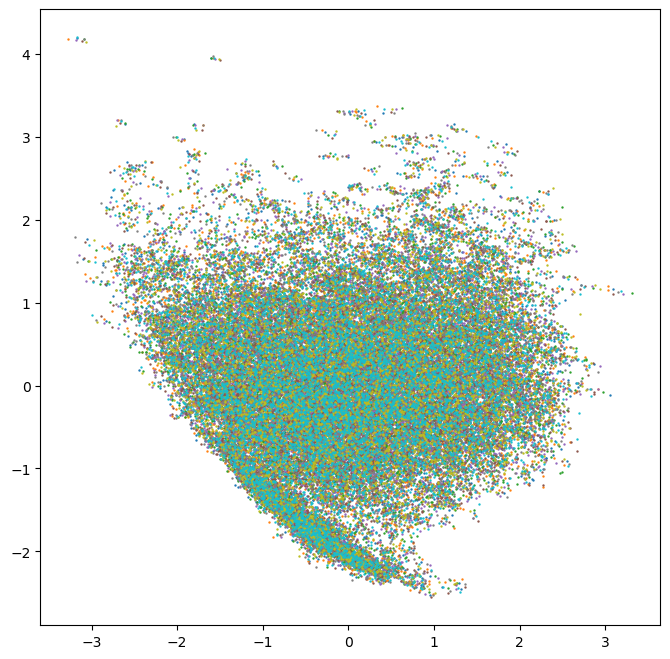

In [26]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
lldm = lldm.to('cuda')
#torch.manual_seed(46)

###################
vi_index = 2
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 1169
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    #last_preembed = torch.load('pre-embeddings-priordecalee.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

sampler = lldm.ddim_sampler
start = train_embeddings[train_point, vi_index, :].cuda().reshape(1, model.c, model.h, model.w)
_, z_seq, _ = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
z_seq = z_seq[:-1].reshape(-1, latent_dim)
x_rec = lldm.decoder(z_seq).reconstruction


z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
for i in range(num_obs):
    plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [49]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)

last_train_data = train_data[:, -1]
last_eval_data = eval_data[:, -1]


BATCH_SIZE = 256

last_train_loader = torch.utils.data.DataLoader(last_train_data, batch_size=BATCH_SIZE, num_workers = 12)
last_val_loader = torch.utils.data.DataLoader(last_eval_data, batch_size=800, num_workers = 12)


In [50]:
import lightning as L
ldm = lldm.pretrained_ldm

#UNFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = True


n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 1e-3
MAX_EPOCHS = 100


model = LitLDM(ldm = ldm, vae = new_vae, lr = lr).to(device)




trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm_retrain', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, last_train_loader, last_val_loader)

#REFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = False

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/eleves-a/2020/meilame.tayebjee/miniconda3/lib ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ldm_retrain/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


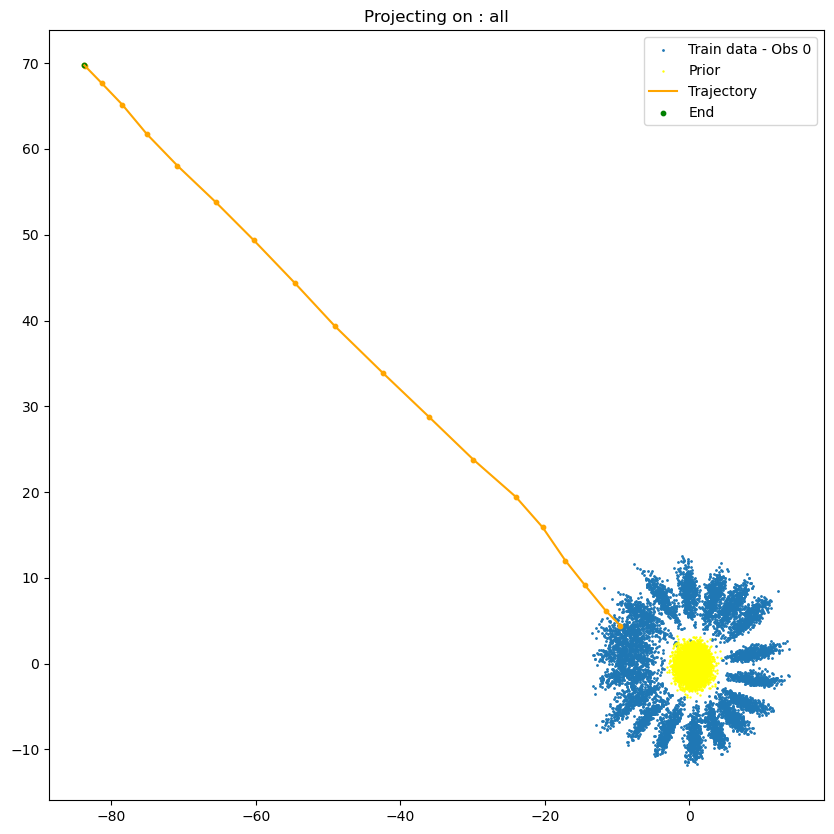

In [41]:
sampler = lldm.ddim_sampler
lldm = lldm.to('cuda')
lldm.eval()

######################
check_index = 0 #6
start = 'embedding' #'embedding'
######################

assert check_index == 6 or check_index == 0
assert start == 'normal' or start == 'embedding'
if check_index == 0:
    check = np.random.randn(10000, model.lat_dim)
if check_index == 6:
    check = last_preembed


check_pca = pca.transform(check)

if start == 'normal':
    start = torch.randn(1, model.c, model.h, model.w).to('cuda')
if start == 'embedding':
    start = train_embeddings[train_point, 0, :].reshape(1, model.c, model.h, model.w).to('cuda')

z, all_z, all_pred_z0 = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)

z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 28, 28)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 28, 28)

start = start.reshape(-1, latent_dim).float()



all_z_pca = pca.transform(all_z.detach().cpu().numpy())
start_pca = pca.transform(start.detach().cpu().numpy())
z_pca = pca.transform(z.detach().cpu().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(train_embeddings_pca[:, check_index, 0], train_embeddings_pca[:, check_index, 1], label=f'Train data - Obs {check_index}', s= 1)
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')

# old = torch.load('preembedding-last.pt')
# #old = torch.load('pre-embeddings-priordecalee.pt')
# old_pca  = pca.transform(old)

#plt.scatter(old_pca[:, 0], old_pca[:, 1], label='Previous Obs 6 embed.', s= 0.5, c = 'red')


plt.plot(all_z_pca[:, 0], all_z_pca[:, 1], label='Trajectory', c = 'orange')
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], c = 'orange', s=10)
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=10, label = "End", c = 'green')
plt.legend()
plt.title('Projecting on : ' + str(projection_index))
plt.show()

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


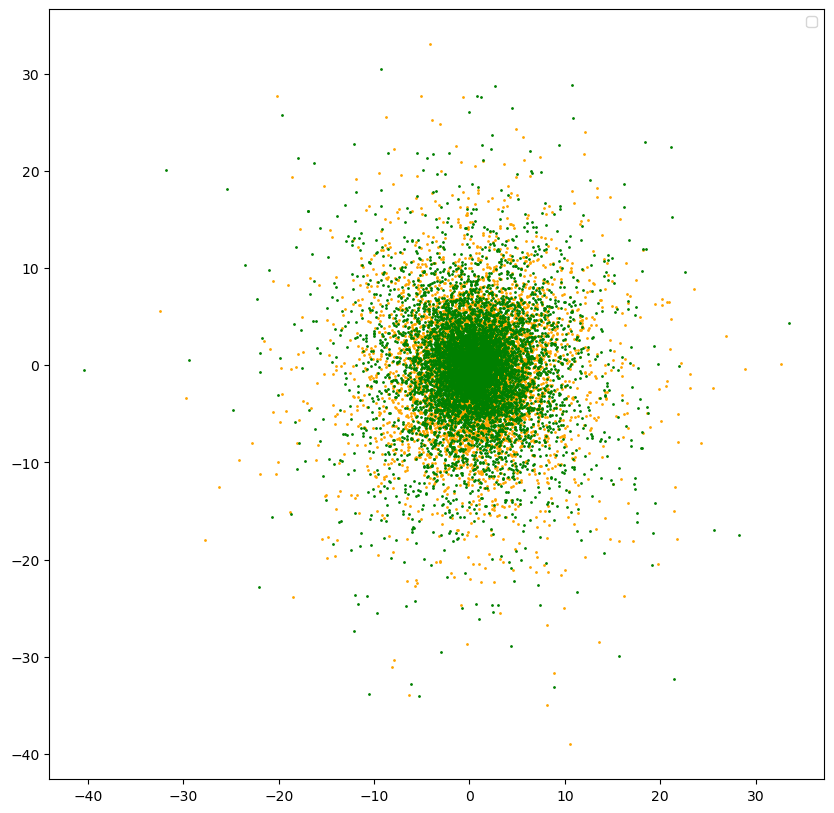

In [42]:
NUM_POINTS = 10000

INDEX = -1

sampler = lldm.ddim_sampler
z = torch.randn(NUM_POINTS, latent_dim).to('cuda')

_, final_z_1, _ = sampler.sample(shape = (NUM_POINTS, 3, 2, 2), x_last = z.reshape(NUM_POINTS, 3, 2, 2), cond = None)
final_z_1  = final_z_1[INDEX, :, :, :, :].reshape(-1, latent_dim)

z_vi_index = z
z_seq = [z_vi_index]

z_for = z_vi_index
batch_size = z_for.shape[0]
vi_index = 0
for i in range(vi_index, lldm.n_obs - 1):
    t = torch.tensor(lldm.diff_t_steps[i]).reshape(1).to(lldm.pretrained_ldm.device).float() #diffusion time-step
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c, lldm.pretrained_ldm.h, lldm.pretrained_ldm.w).float().to(lldm.pretrained_ldm.device)
    noise_pred = lldm.pretrained_ldm(z_for, t) # \eps_\theta (z_t, t)
    z_for, _ = sampler.get_x_prev_and_pred_x0(e_t = noise_pred,
                                                        index = lldm.n_obs -1- i,
                                                        x = z_for,
                                                        temperature=lldm.temperature,
                                                        repeat_noise=False)
    
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c * lldm.pretrained_ldm.h * lldm.pretrained_ldm.w).to(lldm.pretrained_ldm.device)
    z_seq.append(z_for)



z_seq = torch.stack(z_seq, dim = 1)

final_z_2 = z_seq[:, INDEX, :].reshape(-1, latent_dim)

z_pca = pca.transform(z.detach().cpu().numpy())
final_z_pca = pca.transform(final_z_1.detach().cpu().numpy())
final_z_pca_2 = pca.transform(final_z_2.detach().cpu().numpy())

plt.figure(figsize=(10, 10))
#plt.scatter(z_pca[:, 0], z_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')

plt.scatter(final_z_pca[:, 0], final_z_pca[:, 1], c = 'orange', s=1)
plt.scatter(final_z_pca_2[:, 0], final_z_pca_2[: ,1], c = 'green', s=1)
#plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 1, c = 'yellow')
plt.legend()

In [20]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
final_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)
obs_data = train_data[:, 0]
_, mu, log_var = final_vae.retrieveG(obs_data, verbose = True, T_multiplier=0.5, device = 'cuda', addStdNorm=False)






Running Kmedoids
Finding temperature
Best temperature found:  8.50917911529541
Building metric
Increasing T by  0.5


In [28]:
n_samples = 10
batch_size = 10
all_z0 = []

device = 'cpu'
final_vae = final_vae.to(device)
mu = mu.to(device)
for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(final_vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z0.append(z)

p = p[0]
all_z0 = torch.cat(all_z0, dim=0).cpu().detach()
all_z0.shape

torch.Size([10, 12])

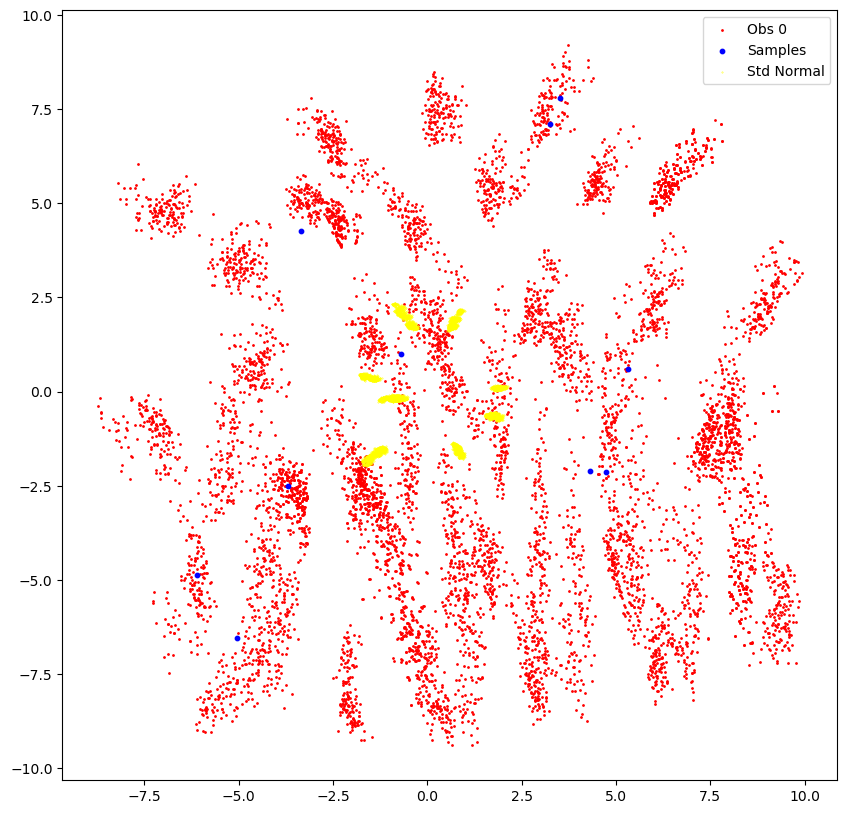

In [29]:
final_vae = final_vae.to(obs_data.device)
obs_manifold = final_vae.encoder(obs_data).embedding.cpu().detach().numpy()
obs_manifold_pca = pca.transform(obs_manifold.reshape(-1, latent_dim))
all_z0_pca = pca.transform(all_z0.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(obs_manifold_pca[:, 0], obs_manifold_pca[:, 1], label='Obs 0', s= 1, c = 'red')
plt.scatter(all_z0_pca[:, 0], all_z0_pca[:, 1], label='Samples', s= 10, c = 'blue')
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Std Normal', s= 0.1, c = 'yellow')
plt.legend()
plt.show()

In [30]:
all_z0 = all_z0.to('cuda')
NUM_OBS = train_data.shape[1]
all_sequences = lldm.ddim_sampler.sample(shape=(all_z0.shape[0], model.c, model.h, model.w), x_last = all_z0.reshape(-1, model.c, model.h, model.w), temperature = 1)[1]
all_sequences = all_sequences[:-1].transpose(0, 1).reshape(all_z0.shape[0], NUM_OBS, latent_dim).cpu()
all_sequences.shape

torch.Size([10, 7, 12])

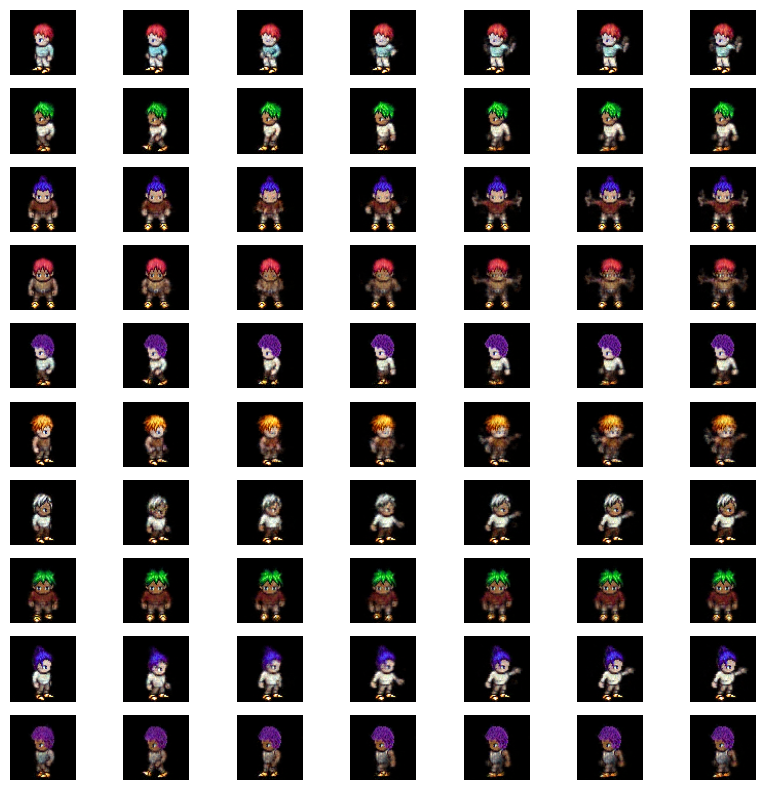

In [31]:
recon = final_vae.decoder(all_sequences.reshape(-1, latent_dim)).reconstruction.reshape(-1, NUM_OBS, 3, 64, 64)
plot_sequence(recon)

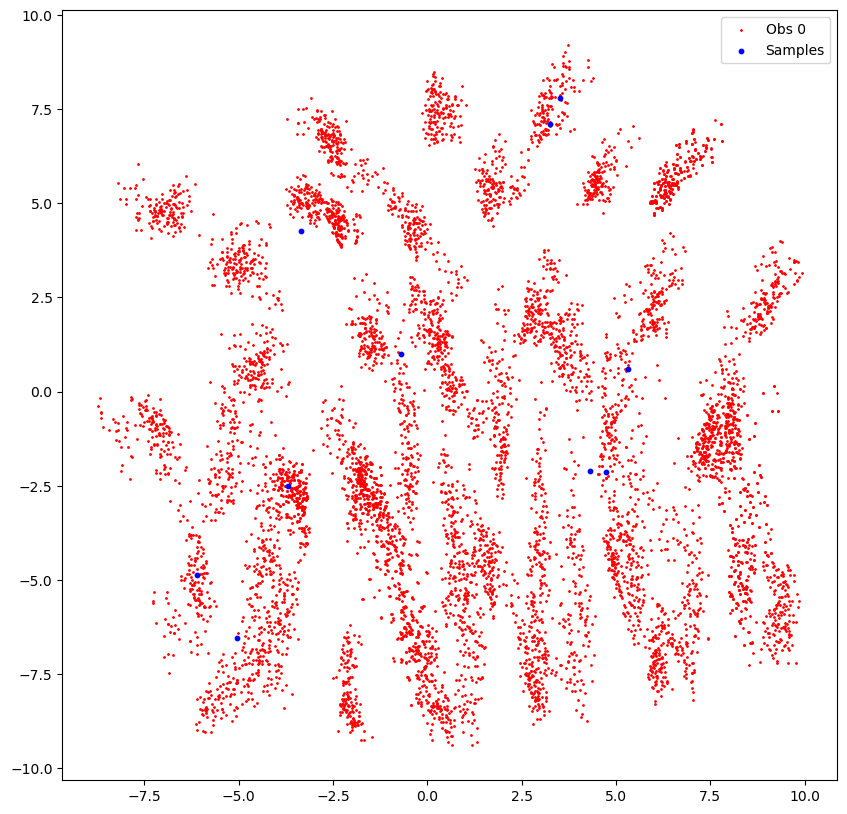

In [32]:
obs_manifold = final_vae.encoder(obs_data).embedding.cpu().detach().numpy()
obs_manifold_pca = pca.transform(obs_manifold.reshape(-1, latent_dim))
all_z0_pca = pca.transform(all_z0.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(obs_manifold_pca[:, 0], obs_manifold_pca[:, 1], label='Obs 0', s= 1, c = 'red')
plt.scatter(all_z0_pca[:, 0], all_z0_pca[:, 1], label='Samples', s= 10, c = 'blue')
plt.legend()
plt.show()

Running Kmedoids
Finding temperature
Best temperature found:  120.40079498291016
Building metric
Increasing T by  0.5
Sampling on the 4th/rd manifold...
Propagating in the past...
Propagating in the future...
Decoding...


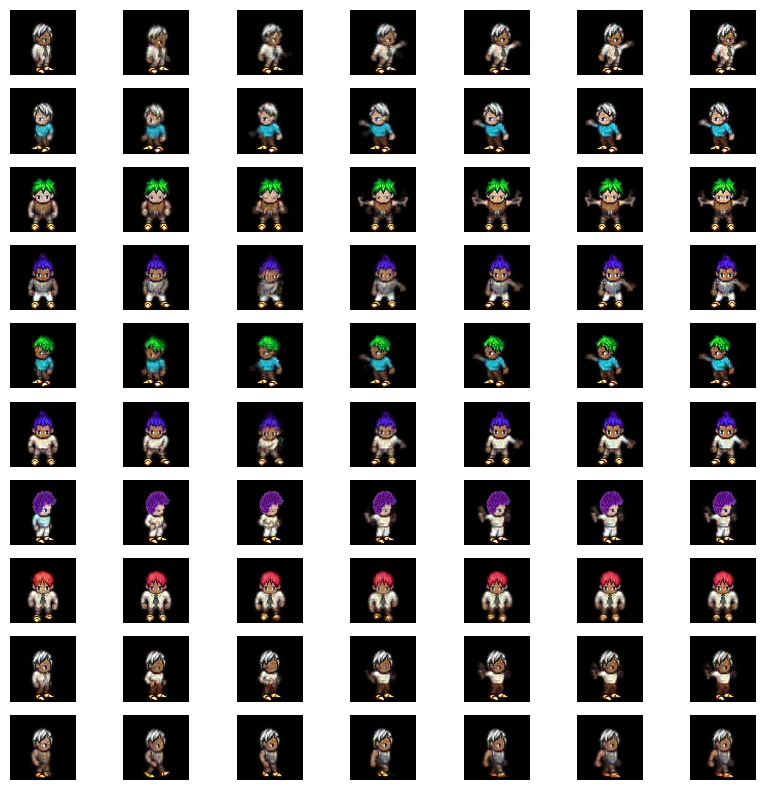

In [34]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=10, vi_index = 4)
plot_sequence(recon_x)

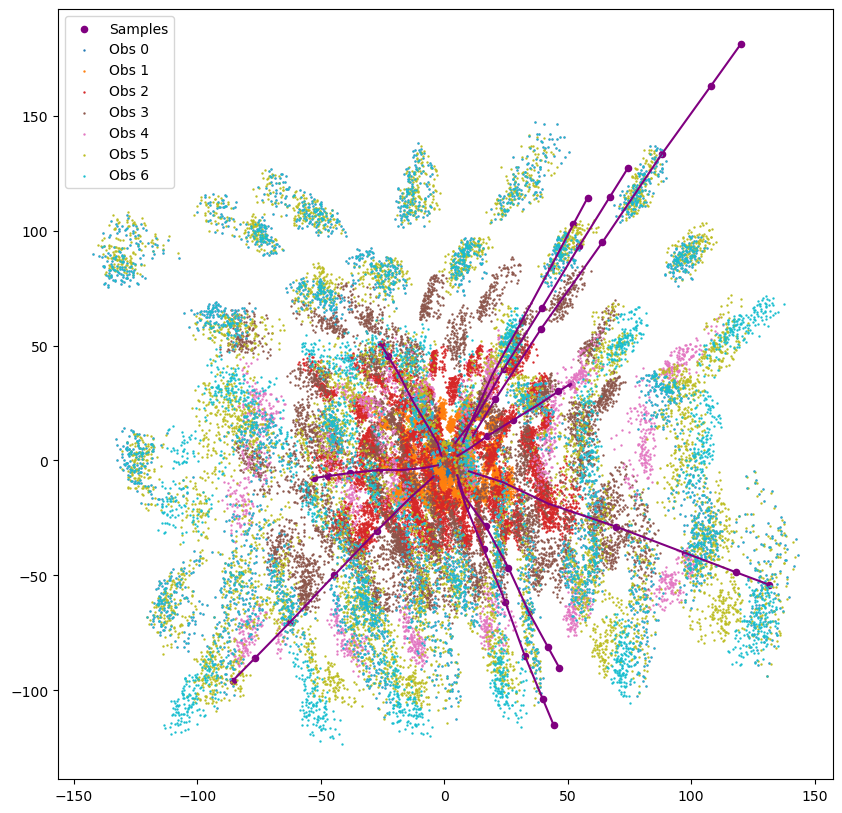

In [35]:
displayed_indexes = range(num_obs)  #range(num_obs)

all_sequences = z_seq
all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
all_sequences_pca = all_sequences_pca.reshape(n_samples, NUM_OBS, 2)
plt.figure(figsize=(10, 10))
plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

for i in range(n_samples):
    plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


plt.legend()
